<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!python -c "import jax; print(jax.default_backend())"

: 

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field, lpt, make_ode_fn

In [3]:
mesh_shape= [256, 256, 256]
box_size  = [256.,256.,256.]
snapshots = jnp.linspace(0.1,1.,2)

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)
    
    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)
    
    # Return the simulation volume at requested 
    return res[0]

In [4]:
res = run_simulation(0.25, 0.8)
# %timeit res = run_simulation(0.25, 0.8)

/feynman/home/dphp/hs276503/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/feynman/home/dphp/hs276503/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/feynman/home/dphp/hs276503/.local

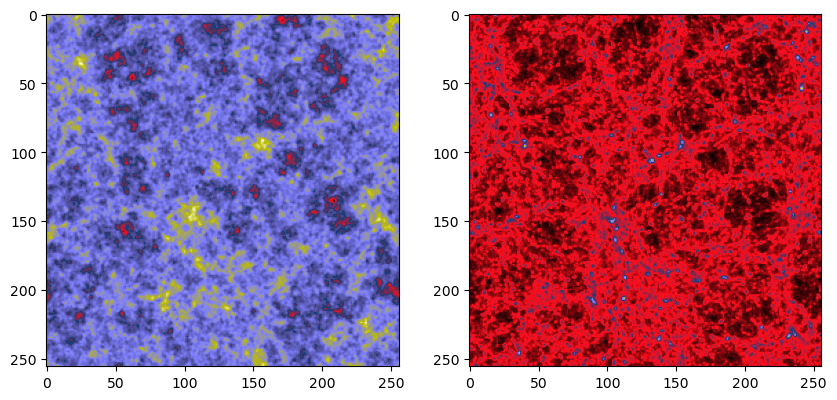

In [11]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow(cic_paint(jnp.zeros(mesh_shape), res[0]).sum(axis=0),cmap='gist_stern')
plt.subplot(122)
plt.imshow(cic_paint(jnp.zeros(mesh_shape), res[1]).sum(axis=0),cmap='gist_stern');